In [2]:
import os
from pathlib import Path
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.preprocessing.sequence as sequence
import tensorflow.keras.utils as utils

import matplotlib.pyplot as plt
import pickle

In [3]:
%matplotlib inline

In [3]:
# on multi gpu machines, set which gpu to use
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15098937342341217294
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11242492127774407982
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12340656139343836968
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15864515789
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1320703299036395793
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [5]:
from keras import backend
backend.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
#read in the csvs obtained from 03_tags_clustering
chem = pd.read_csv("../data/equation/chemistry_post_eq_tag_id.csv", lineterminator='\n')
physics = pd.read_csv("../data/equation/physics_post_eq_tag_id.csv", lineterminator='\n')
bio = pd.read_csv("../data/equation/biology_post_eq_tag_id.csv", lineterminator='\n')

In [5]:
print(chem.shape[0])
print(physics.shape[0])
print(bio.shape[0])

15830
35448
12571


In [6]:
df = pd.concat([bio, chem, physics], ignore_index=True)
df.head(50)

/Users/shuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,Cluster_label,Equation,Id,Label,Tags
0,biology,v = 6d,424,biology,<human-biology><neuroscience>
1,biology,v,424,biology,<human-biology><neuroscience>
2,biology,d,424,biology,<human-biology><neuroscience>
3,biology,v = \sqrt{\frac{i_\text{Na max}}{r_i c_m^2 V_\...,424,biology,<human-biology><neuroscience>
4,biology,\ce{O2},456,biology,NaN
5,biology,\ce{C_6H12O6 + 6 O2 -&gt; 6 CO2 + 6 H2O + heat},456,biology,NaN
6,biology,V_d=k\frac{\large a.([C_2]-[C_1])}{\large l},1000,biology,NaN
7,biology,"counts, mids=h",1207,biology,NaN
8,biology,even &lt;- (df,1207,biology,NaN
9,biology,\frac{T_{min}-T_{max}}{2}- T_{base},1272,biology,<plant-physiology>


In [7]:
df.dropna(subset = ['Equation'], inplace = True)

In [8]:
df.groupby(['Cluster_label'])['Cluster_label'].count()

Cluster_label
biology                12568
chemistry-inorganic     8519
chemistry-organic       7310
physics-quantum        12046
physics-relativity     23390
Name: Cluster_label, dtype: int64

In [9]:
df['Equation'] = df['Equation'].astype(str)

In [10]:
df = df[df.apply(lambda row: len(row.Equation) > 3, axis = 1)]

In [11]:
df.groupby(['Cluster_label'])['Cluster_label'].count()

Cluster_label
biology                 7725
chemistry-inorganic     7867
chemistry-organic       6739
physics-quantum         9260
physics-relativity     15681
Name: Cluster_label, dtype: int64

In [12]:
df.rename(columns={"Label": "Source"}, inplace = True)

In [12]:
df.head()

,Cluster_label,Equation,Id,Source,Tags
0,biology,v = 6d,424,biology,<human-biology><neuroscience>
3,biology,v = \sqrt{\frac{i_\text{Na max}}{r_i c_m^2 V_\...,424,biology,<human-biology><neuroscience>
4,biology,\ce{O2},456,biology,NaN
5,biology,\ce{C_6H12O6 + 6 O2 -&gt; 6 CO2 + 6 H2O + heat},456,biology,NaN
6,biology,V_d=k\frac{\large a.([C_2]-[C_1])}{\large l},1000,biology,NaN


In [13]:
def split_data(df, frac=0.1):
    """
    Split the data by the post id.
    Equations from the same post will be in the same set.
    """
    split_by = df.Id
    post_ids = df.Id.unique()
    N = len(post_ids)
    
    test_posts = np.random.choice(post_ids, int(N * frac))
    n_test = len(test_posts)
    test_condition = df.Id.isin(test_posts)
    return df[~test_condition], df[test_condition]

In [14]:
np.random.seed(1)
print('Null Data: ', df.Equation.isnull().sum())
df.dropna(subset=['Equation'], inplace=True)
df = df.drop_duplicates(subset=['Equation', 'Source', 'Cluster_label'])
train_df, test_df = split_data(df, 0.1)
train_df, val_df = split_data(train_df, 0.1)

print(f'Training rows: {train_df.shape[0]}')
print(f'Val rows: {val_df.shape[0]}')
print(f'Test rows: {test_df.shape[0]}')

Null Data:  0
Training rows: 26257
Val rows: 2593
Test rows: 2856


In [15]:
class Tokenizer:
    """Convert chars to ints"""
    def __init__(self):
        self.UNK = '<UNK>'  # Unknown
        self.BOS = '<BOS>'  # Begin of string
        self.EOS = '<EOS>'  # End of string
        self.PAD = '<PAD>'  # Padding
        self.char_to_idx = dict()
        self.idx_to_char = dict()
        self.vocab = []
        
        self.specials = [self.PAD, self.BOS, self.EOS, self.UNK]
        for c in self.specials: self.add(c)
        
    
    def __getitem__(self, c: str):
        try:
            return self.char_to_idx[c]
        except KeyError:
            return self.char_to_idx[self.UNK]
    
    def fit(self, sequences):
        """Create the vocab from a sequence of strings"""
        chars = set.union(*map(set, sequences))
        for char in chars: self.add(char)

    def add(self, c: str):
        """Add the character if its not in the vocab, else do nothing"""
        if self.char_to_idx.get(c) is None:
            self.char_to_idx[c] = len(self.vocab)
            self.idx_to_char[len(self.vocab)] = c
            self.vocab.append(c)
        return len(self.vocab)

    
def encode_sequence(seq, tokenizer):
    return [tokenizer[tokenizer.BOS]] + [tokenizer[c] for c in seq] + [tokenizer[tokenizer.EOS]]

In [16]:
def encode_sequence_base(seq, tokenizer):
    return [tokenizer[c] for c in seq]

# preprocessing data

In [17]:
tokenizer = Tokenizer()
tokenizer.fit(train_df.Equation)

# convert string to list of int
train_df['seq'] = train_df.Equation.apply(encode_sequence_base, args=(tokenizer,))
val_df['seq'] = val_df.Equation.apply(encode_sequence_base, args=(tokenizer,))
test_df['seq'] = test_df.Equation.apply(encode_sequence_base, args=(tokenizer,))

train_df['length'] = train_df.seq.apply(len)
val_df['length'] = val_df.seq.apply(len)
test_df['length'] = test_df.seq.apply(len)

labels = train_df.Cluster_label.unique()
label_map = {label: i for i, label in enumerate(labels)}

train_df['Label'] = train_df.Cluster_label.map(label_map)
val_df['Label'] = val_df.Cluster_label.map(label_map)
test_df['Label'] = test_df.Cluster_label.map(label_map)

/Users/shuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/shuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/shuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [18]:
df_all = pd.concat([train_df, val_df, test_df], ignore_index=True)

In [19]:
df_all['seq_list'] = df_all.apply(lambda row: [str(i) for i in row.seq], axis = 1)

# keep every sequence length 32

In [20]:
seq_list_truncate = []
for i, row in df_all.iterrows():
    if len(row.seq_list) < 32:
        row.seq_list.extend([str(0)]*(32-len(row.seq_list)))
    seq_list_truncate.append(row.seq_list[:33])
df_all['seq_list_truncate'] = seq_list_truncate

In [21]:
df_all['seq_str'] = df_all.apply(lambda row: ",".join(row.seq_list_truncate), axis = 1)

In [24]:
df_all.head()

,Cluster_label,Equation,Id,Source,Tags,seq,length,Label,seq_list,seq_list_truncate,seq_str
0,biology,v = 6d,424,biology,<human-biology><neuroscience>,"[154, 88, 70, 88, 147, 11]",6,0,"[154, 88, 70, 88, 147, 11, 0, 0, 0, 0, 0, 0, 0...","[154, 88, 70, 88, 147, 11, 0, 0, 0, 0, 0, 0, 0...","154,88,70,88,147,11,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
1,biology,v = \sqrt{\frac{i_\text{Na max}}{r_i c_m^2 V_\...,424,biology,<human-biology><neuroscience>,"[154, 88, 70, 88, 71, 43, 87, 174, 37, 8, 71, ...",58,0,"[154, 88, 70, 88, 71, 43, 87, 174, 37, 8, 71, ...","[154, 88, 70, 88, 71, 43, 87, 174, 37, 8, 71, ...","154,88,70,88,71,43,87,174,37,8,71,89,174,74,83..."
2,biology,\ce{O2},456,biology,NaN,"[71, 83, 171, 8, 86, 104, 41]",7,0,"[71, 83, 171, 8, 86, 104, 41, 0, 0, 0, 0, 0, 0...","[71, 83, 171, 8, 86, 104, 41, 0, 0, 0, 0, 0, 0...","71,83,171,8,86,104,41,0,0,0,0,0,0,0,0,0,0,0,0,..."
3,biology,\ce{C_6H12O6 + 6 O2 -&gt; 6 CO2 + 6 H2O + heat},456,biology,NaN,"[71, 83, 171, 8, 47, 123, 147, 77, 136, 104, 8...",47,0,"[71, 83, 171, 8, 47, 123, 147, 77, 136, 104, 8...","[71, 83, 171, 8, 47, 123, 147, 77, 136, 104, 8...","71,83,171,8,47,123,147,77,136,104,86,147,88,10..."
4,biology,"counts, mids=h",1207,biology,NaN,"[83, 34, 148, 31, 37, 43, 13, 88, 127, 73, 11,...",14,0,"[83, 34, 148, 31, 37, 43, 13, 88, 127, 73, 11,...","[83, 34, 148, 31, 37, 43, 13, 88, 127, 73, 11,...","83,34,148,31,37,43,13,88,127,73,11,43,70,16,0,..."


In [22]:
train_df, test_df = split_data(df_all, 0.1)
train_df, val_df = split_data(train_df, 0.1)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectorizer.fit(train_df['seq_str'])

train_X = vectorizer.transform(train_df['seq_str'])
val_X = vectorizer.transform(val_df['seq_str'])
test_X = vectorizer.transform(test_df['seq_str'])

# baseline model: logistic regression

In [50]:
from sklearn.linear_model import LogisticRegression
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression()
logisticRegr.fit(train_X, train_df['Cluster_label'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [53]:
# Use score method to get accuracy of model
score = logisticRegr.score(val_X, val_df['Cluster_label'])
print(score)

0.6345514950166113


In [54]:
# Use score method to get accuracy of model
score = logisticRegr.score(test_X, test_df['Cluster_label'])
print(score)

0.6538595878449179


# baseline model: SVC

In [55]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(train_X, train_df['Cluster_label'])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [56]:
score_svc = svc.score(test_X, test_df['Cluster_label'])
score_svc

0.5986727209221097

# baseline model: multinomial naive bayes

In [24]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()

In [26]:
from sklearn.model_selection import cross_validate
scores = cross_validate(clf, train_X, train_df['Cluster_label'], cv=5, return_train_score=True)

In [27]:
scores.keys()

dict_keys(['fit_time', 'score_time', 'test_score', 'train_score'])

In [29]:
print("test score is " + str(scores['test_score'].mean()))
print("train score is " + str(scores['train_score'].mean()))

test score is 0.5841341160565718
train score is 0.5968924686928332


# use neural network 

In [57]:
tokenizer = Tokenizer()
tokenizer.fit(train_df.Equation)

# convert string to list of int
train_df['seq'] = train_df.Equation.apply(encode_sequence, args=(tokenizer,))
val_df['seq'] = val_df.Equation.apply(encode_sequence, args=(tokenizer,))
test_df['seq'] = test_df.Equation.apply(encode_sequence, args=(tokenizer,))

train_df['length'] = train_df.seq.apply(len)
val_df['length'] = val_df.seq.apply(len)
test_df['length'] = test_df.seq.apply(len)

labels = train_df.Cluster_label.unique()
label_map = {label: i for i, label in enumerate(labels)}

train_df['Label'] = train_df.Cluster_label.map(label_map)
val_df['Label'] = val_df.Cluster_label.map(label_map)
test_df['Label'] = test_df.Cluster_label.map(label_map)


/Users/shuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/shuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/shuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [58]:
encode_sequence('1234', tokenizer)

[1, 142, 109, 38, 13, 2]

In [59]:
tokenizer['4']

13

In [60]:
len(tokenizer.vocab)

183

In [61]:
label_map

{'biology': 0,
 'chemistry-organic': 1,
 'chemistry-inorganic': 2,
 'physics-relativity': 3,
 'physics-quantum': 4}

In [64]:
train_df.drop(columns = ['seq_list', 'seq_list_truncate','seq_str'], inplace = True)

In [65]:
train_df.sample(10)

,Cluster_label,Equation,Id,Source,Tags,seq,length,Label
26468,biology,^{(2)},56775,biology,<biochemistry><pharmacology><endocrinology><me...,"[1, 175, 8, 64, 109, 9, 43, 2]",8,0
11851,physics-quantum,"E &lt; \lim_{|x|\rightarrow \infty}V(x),",65636,physics,<mathematical-physics><schroedinger-equation><...,"[1, 92, 60, 92, 66, 4, 39, 70, 92, 74, 4, 76, ...",44,4
25512,physics-quantum,"|2,-1 \rangle_c = \frac{1}{\sqrt{2}} \big( |0,...",464735,physics,<quantum-mechanics><operators><quantum-spin><r...,"[1, 116, 109, 15, 150, 142, 92, 74, 182, 77, 3...",81,4
27561,physics-quantum,"\hat{q},\ \hat{p}",119474,physics,<quantum-mechanics><operators><momentum><hilbe...,"[1, 74, 17, 77, 39, 8, 91, 43, 15, 74, 92, 74,...",19,4
21881,physics-quantum,"\left[ \vec{L},\: \vec{A} \cdot \vec{B}\right]...",370954,physics,<quantum-mechanics><angular-momentum><operator...,"[1, 74, 4, 179, 93, 39, 78, 92, 74, 161, 179, ...",52,4
1595,biology,\frac{p}{1-p}=\frac{0.5}{1-0.5}=\frac{0.5}{0.5}=1,31957,biology,NaN,"[1, 74, 93, 182, 77, 87, 8, 148, 43, 8, 142, 1...",51,0
16533,physics-relativity,S^{0},219635,physics,<general-relativity><special-relativity>,"[1, 5, 175, 8, 165, 43, 2]",7,3
8252,chemistry-inorganic,\ce{HMnO2^-},69282,chemistry,<inorganic-chemistry><ionic-compounds><transit...,"[1, 74, 87, 179, 8, 81, 163, 32, 90, 109, 175,...",14,2
30322,physics-quantum,\langle Q^2 \rangle = q^2,119963,physics,<quantum-mechanics><homework-and-exercises><op...,"[1, 74, 4, 77, 32, 180, 4, 179, 92, 99, 175, 1...",29,4
31492,physics-quantum,"\hat{U}(t_1,t_2) = e^{-\frac{\hat{H}}{\hbar}(t...",446185,physics,<quantum-mechanics><operators><hilbert-space>,"[1, 74, 17, 77, 39, 8, 113, 43, 64, 39, 129, 1...",58,4


# Generate data

In [25]:
class DataGenerator(utils.Sequence):
    def __init__(self, df, batch_size: int = 32, shuffle: bool = False, weight: bool = False, n_class: int = 3):
        self.df = df
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.weight = weight
        self.n_class = n_class
        self.class_weight =  self.compute_class_weight(self.n_class) if self.weight else np.ones((self.n_class,))
        
        if self.shuffle:
            self.df = self.df.sample(frac=1)
            

    def get_data_at_index(self, batch_idx):
        offset = self.batch_size * batch_idx
        return self.df.iloc[offset: offset+self.batch_size]
    
    def __getitem__(self, batch_idx: int):
        batch = self.get_data_at_index(batch_idx)
        if self.shuffle:
            batch = batch.sample(frac=1)

        X = sequence.pad_sequences(
            batch.seq,
            maxlen=min( max(batch.length), 32),
            truncating='post',
        )
        Y = batch.Label.values
        w = np.array([self.class_weight[label] for label in Y])
        return X, Y, w
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1)
            
    def __len__(self):
        return int(np.ceil( self.df.shape[0] / self.batch_size ))
    
    def compute_class_weight(self, n_classes):
        n_samples = self.df.shape[0]
        return n_samples / (n_classes * np.bincount(self.df.Label.values))


In [26]:
class Mask(layers.Layer):
    def call(self, inputs):
        value = tf.cast(0, dtype=inputs.dtype)
        is_zero = tf.equal(inputs, value)
        return tf.cast(tf.logical_not(is_zero), tf.float32)

        
class ApplyMask(layers.Layer):
    def call(self, inputs):
        data, mask = inputs
        mask = tf.expand_dims(mask, axis=-1)  # (N, T, 1)
        return tf.multiply(data, mask)

# Model building

In [47]:
def clf_model(tokenizer, emb, n_kernels, kernel_width, n_class):
    
    # define layers
    input = layers.Input(batch_shape=(None, None))  # (N, T)
    embedding_layer = layers.Embedding(len(tokenizer.vocab), emb, mask_zero=False, name='embedding')  # (N, T, emb)
    mask_layer = Mask(name='mask')  # (N, T)
    conv_layer = layers.Conv1D(
        n_kernels, kernel_width, 
        activation='tanh',
        kernel_initializer='he_normal',
        padding='same',
        name='conv'
    )  # (N, T, n_kernels), selects 3-grams
    apply_mask_layer = ApplyMask(name='apply_mask')  # (N, T, n_kernels), zero the timesteps that were padding
    lstm1_layer = layers.LSTM(n_kernels, return_sequences = True, dropout = 0.3, name='lstm1') # (N, e)
    lstm2_layer = layers.LSTM(n_kernels, return_sequences = True, dropout=0.3, name='lstm2')
    lstm3_layer = layers.LSTM(n_kernels, dropout=0.3, name='lstm3')
    softmax_layer = layers.Dense(n_class, activation='softmax', name='output')
    
    # call layers
    embedding = embedding_layer(input)
    mask = mask_layer(input)
    conv = conv_layer(embedding)
    conv = apply_mask_layer([conv, mask])
    encoded = lstm1_layer(conv)
    encoded = lstm2_layer(encoded)
    encoded = lstm3_layer(encoded)
    output = softmax_layer(encoded)
    model = models.Model(input, output)
    return model
    
def compile_model(model):
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['sparse_categorical_accuracy']
    )


# Evaluation

## evaluation tools

In [28]:
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

%matplotlib notebook

def plot_confusion_matrix(y_true, y_pred, classes, name,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    plt.savefig('../result/confusion_matrix/' + name + '.png')
    return ax

In [29]:
def predict_on_df(model, df, batch_size, n_class):
    dg = DataGenerator(df, batch_size=batch_size, shuffle=False, weight = False, n_class = n_class)
    yhat = model.predict_generator(dg)
    pred_index = yhat.argmax(axis=1)
    pred_conf = yhat.max(axis=1)
    df['pred_index'] = pred_index
    df['pred_label'] = df.pred_index.apply(lambda x: list(label_map.keys())[x])
    df['pred_conf'] = pred_conf
    df['match'] = df['pred_index'] == df['Label']
    return df


def display_top_losses(prediction_df, k: int = 10):
    wrong_condition = ~prediction_df.match
    wrong_df = prediction_df[wrong_condition]
    return wrong_df.sort_values('pred_conf', ascending=False).iloc[0:k][['Equation', 'pred_label', 'Cluster_label', 'pred_index', 'Label', 'pred_conf']]
    
def predict_from_str(equation, model, tokenizer):
    X = np.array([encode_sequence(equation, tokenizer)])
    yhat = model.predict(X)
    pred_index = yhat.argmax()
    label = [label for label, i in label_map.items() if i==pred_index][0]
    return {
        'yhat': yhat.tolist(),
        'pred_index': pred_index,
        'label': label
           }

# model: cluster size = 5, batch_size = 128, emb = 32, n_kernels = 128, kernel_width = 3, epoches = 30 GRU dropout = 0.3

In [48]:
batch_size = 128
n_class = 5
train_dg = DataGenerator(train_df, batch_size=batch_size, shuffle=True, weight=True, n_class = n_class)
val_dg = DataGenerator(val_df, batch_size=batch_size, shuffle=False, weight=False, n_class = n_class)
emb = 32
n_kernels = 128
kernel_width = 3
name = "model7_cluster5_epoch30"
model = clf_model(tokenizer, emb, n_kernels, kernel_width, n_class)  # initialize the weights
compile_model(model)  # set the loss fn and optimizer
print(model.summary())  # check the number of parameters


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 32)     7008        input_4[0][0]                    
__________________________________________________________________________________________________
conv (Conv1D)                   (None, None, 128)    12416       embedding[0][0]                  
__________________________________________________________________________________________________
mask (Mask)                     (None, None)         0           input_4[0][0]                    
__________________________________________________________________________________________________
apply_mask

In [50]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
filepath = "../result/model/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
early_stop = EarlyStopping(monitor='loss', min_delta=0.001, patience=3, mode='min', verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min', period=1)

In [45]:
history = model.fit_generator(train_dg, validation_data=val_dg, epochs = 20,
      callbacks = [early_stop,checkpoint])

Epoch 1/20


/jet/var/python/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


431/432 [============================>.] - ETA: 0s - loss: 1.1931 - sparse_categorical_accuracy: 0.4461
Epoch 00001: val_loss improved from inf to 1.03021, saving model to ../result/model/weights-improvement-01-1.03.hdf5
432/432 [==============================] - 55s 128ms/step - loss: 1.1922 - sparse_categorical_accuracy: 0.4464 - val_loss: 1.0302 - val_sparse_categorical_accuracy: 0.5306
Epoch 2/20
431/432 [============================>.] - ETA: 0s - loss: 0.9825 - sparse_categorical_accuracy: 0.5648
Epoch 00002: val_loss improved from 1.03021 to 0.86485, saving model to ../result/model/weights-improvement-02-0.86.hdf5
432/432 [==============================] - 51s 117ms/step - loss: 0.9824 - sparse_categorical_accuracy: 0.5651 - val_loss: 0.8649 - val_sparse_categorical_accuracy: 0.6310
Epoch 3/20
431/432 [============================>.] - ETA: 0s - loss: 0.9053 - sparse_categorical_accuracy: 0.6037
Epoch 00003: val_loss improved from 0.86485 to 0.85495, saving model to ../result/mo

In [ ]:
history = model.fit_generator(train_dg, validation_data=val_dg, epochs = 20,
      callbacks = [early_stop,checkpoint])

Epoch 1/20
431/432 [============================>.] - ETA: 0s - loss: 0.9776 - sparse_categorical_accuracy: 0.5552
Epoch 00001: val_loss improved from inf to 0.92314, saving model to ../result/model/weights-improvement-01-0.92.hdf5
432/432 [==============================] - 83s 192ms/step - loss: 0.9773 - sparse_categorical_accuracy: 0.5554 - val_loss: 0.9231 - val_sparse_categorical_accuracy: 0.5983
Epoch 2/20
431/432 [============================>.] - ETA: 0s - loss: 0.9135 - sparse_categorical_accuracy: 0.5988
Epoch 00002: val_loss improved from 0.92314 to 0.84157, saving model to ../result/model/weights-improvement-02-0.84.hdf5
432/432 [==============================] - 83s 191ms/step - loss: 0.9131 - sparse_categorical_accuracy: 0.5989 - val_loss: 0.8416 - val_sparse_categorical_accuracy: 0.6405
Epoch 3/20
431/432 [============================>.] - ETA: 0s - loss: 0.8698 - sparse_categorical_accuracy: 0.6223
Epoch 00003: val_loss did not improve from 0.84157
432/432 [=============

In [ ]:
# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)

<IPython.core.display.Javascript object>


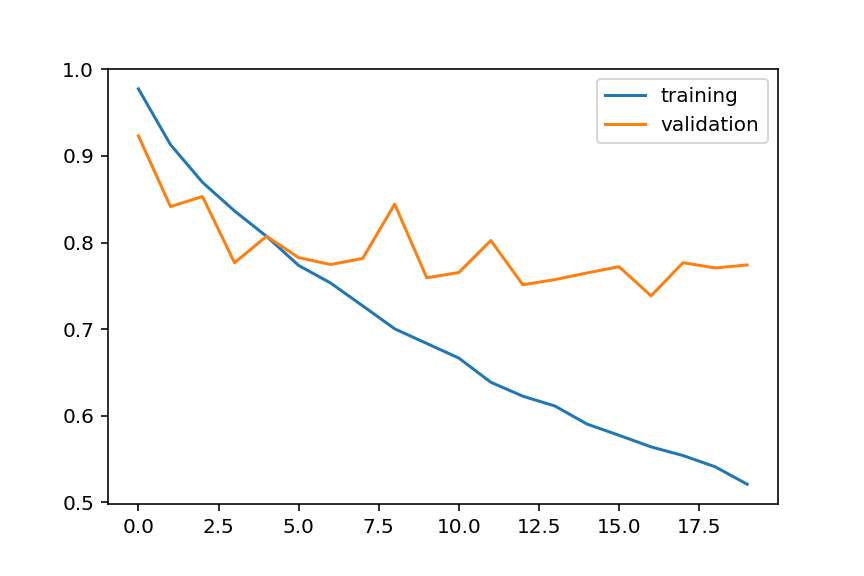

In [52]:
with open('../result/loss/' + name, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()
plt.savefig('../result/loss/' + name + '.png')

In [54]:
with open('../result/loss/model7_cluster5_epoch30', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

/jet/var/python/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/jet/var/python/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/jet/var/python/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/inde

Confusion matrix, without normalization
[[ 259   29   27   56   51]
 [   9  229   64    9    8]
 [  25   92  168   12    9]
 [ 224   24   20 2143  569]
 [ 205   21   27  542 1587]]


/jet/var/python/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


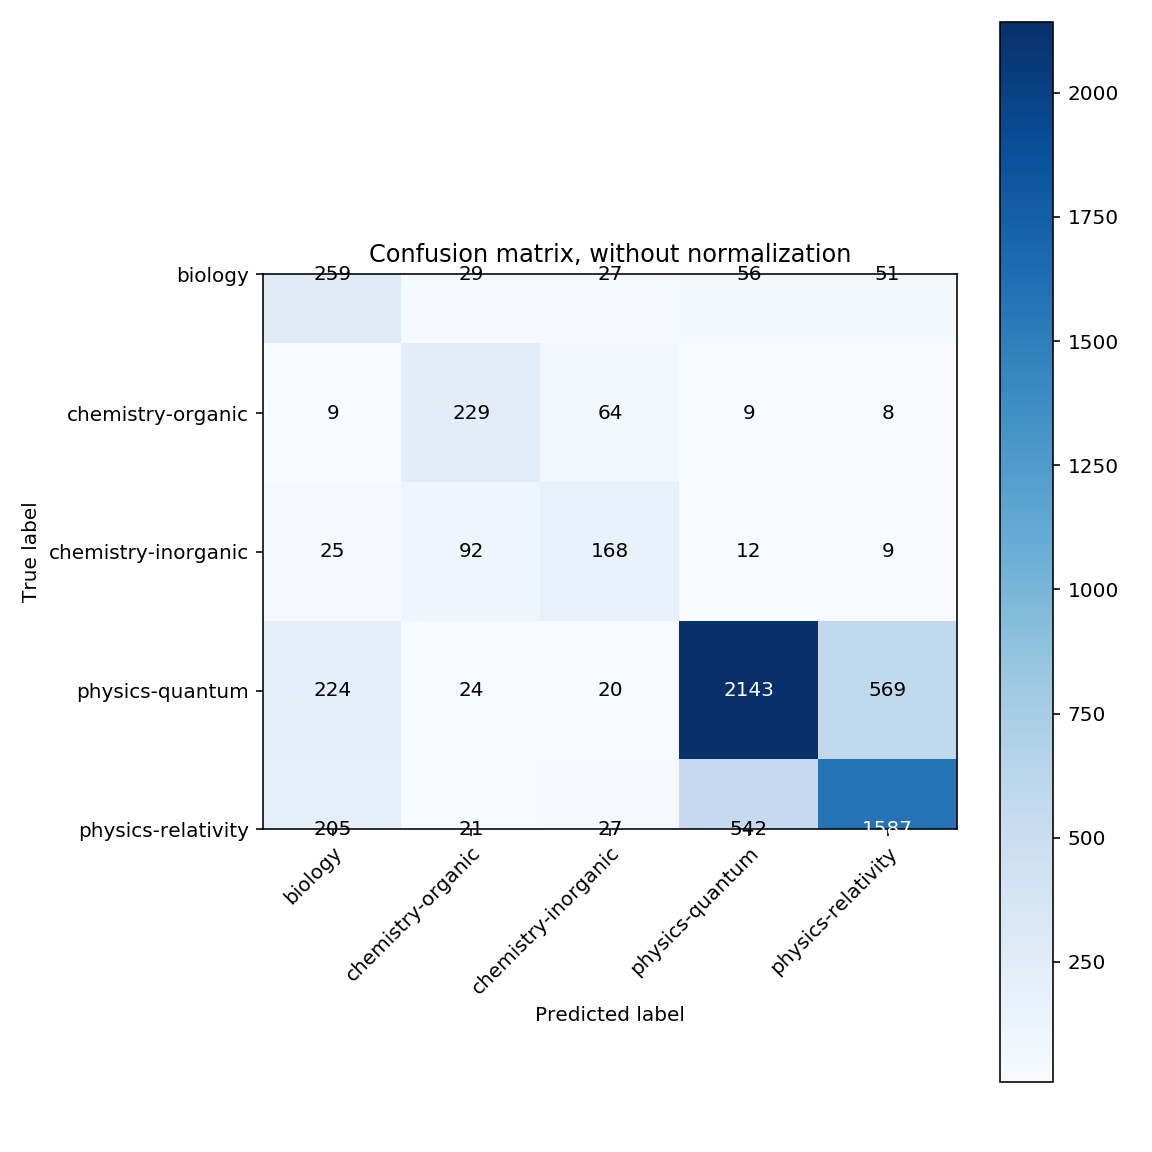

In [53]:
predictions = predict_on_df(model, test_df, batch_size, n_class)
plot_confusion_matrix(predictions.Label, predictions.pred_index, np.array(list(label_map.keys())), name)

In [55]:
name = "model7_cluster5_epoch30_normalized"

Normalized confusion matrix
[[0.61374408 0.06872038 0.06398104 0.13270142 0.12085308]
 [0.02821317 0.71786834 0.20062696 0.02821317 0.02507837]
 [0.08169935 0.30065359 0.54901961 0.03921569 0.02941176]
 [0.07516779 0.00805369 0.00671141 0.71912752 0.1909396 ]
 [0.08606213 0.00881612 0.01133501 0.22753988 0.66624685]]


<IPython.core.display.Javascript object>


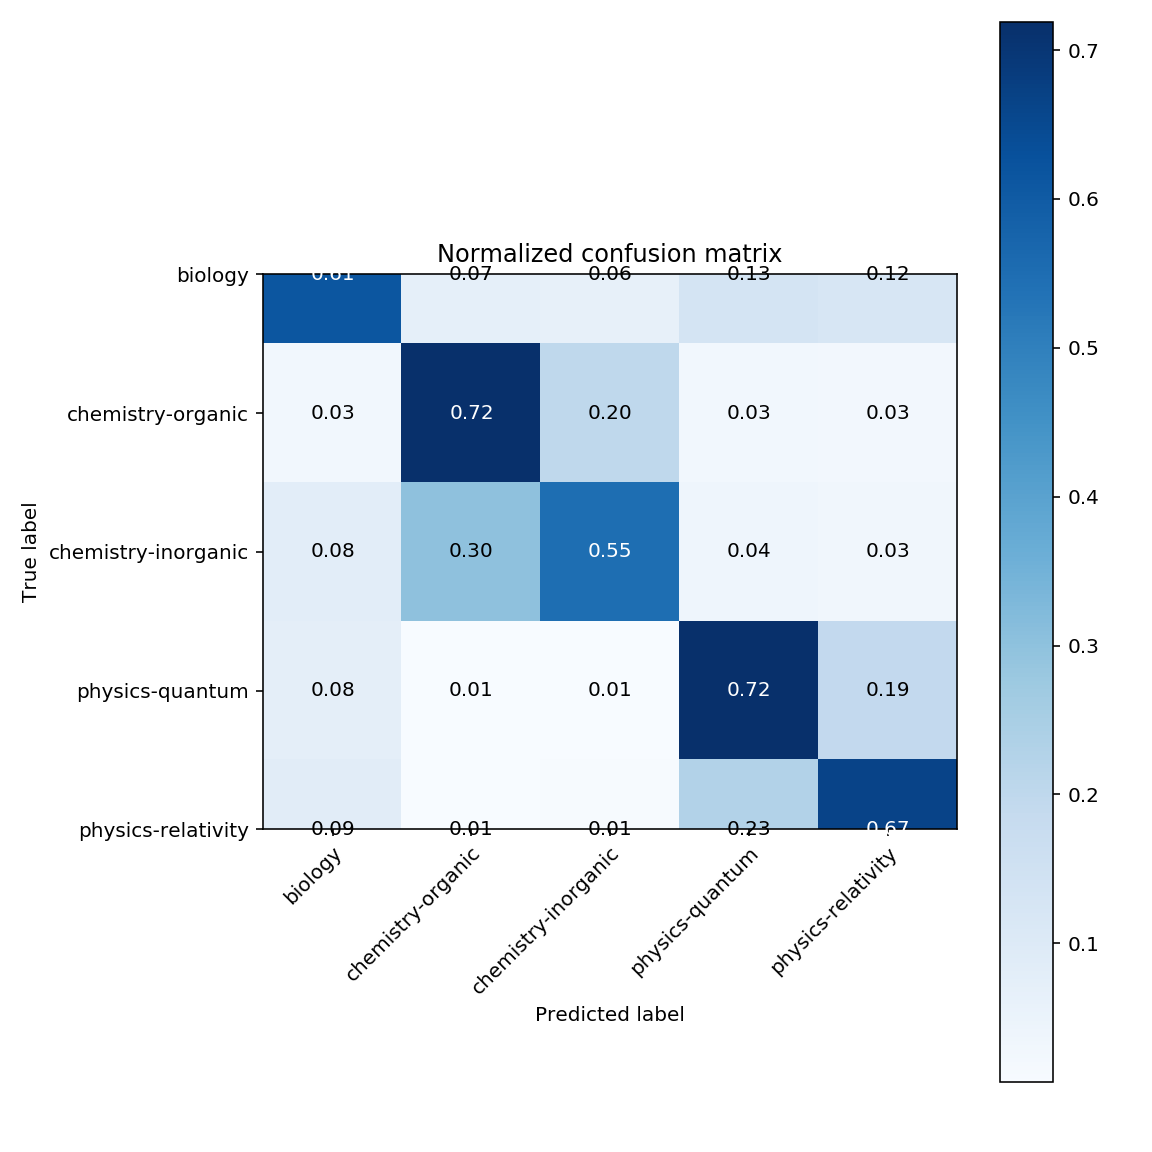

In [56]:
plot_confusion_matrix(predictions.Label, predictions.pred_index, np.array(list(label_map.keys())), name, normalize = True)

In [57]:
display_top_losses(predictions, 100)

,Equation,pred_label,Cluster_label,pred_index,Label,pred_conf
18267,\ce{3ArOH + FeCl3 → Fe(OAr)3 + 3HCl},chemistry-inorganic,chemistry-organic,2,1,0.996985
21323,\ce{H-C#{N:}},chemistry-organic,chemistry-inorganic,1,2,0.996163
18269,\ce{[Fe(OAr)6]^3-},chemistry-inorganic,chemistry-organic,2,1,0.995951
18268,\ce{6 ArOH + FeCl3 -&gt; [Fe(OAr)6]^3- + 3H+ +...,chemistry-inorganic,chemistry-organic,2,1,0.994221
19172,\ce{R-O-N=O},chemistry-organic,chemistry-inorganic,1,2,0.994128
3582,\ce{HF(aq) -&gt; F^-.... H3O+},chemistry-inorganic,biology,2,0,0.993966
47468,\mathrm{d}LIPS_n,chemistry-inorganic,physics-quantum,2,3,0.993860
6905,\ce{Glu + NH3-&gt;Glutamine},chemistry-inorganic,biology,2,0,0.993658
14486,\ce{Br-C-Br},chemistry-organic,chemistry-inorganic,1,2,0.993266
18728,\ce{K[Al(OH)3] + C2H2O4.2H2O -&gt;K3[Al(COO)3]...,chemistry-organic,chemistry-inorganic,1,2,0.992709


# load model

In [58]:
from tensorflow.keras.models import load_model
model = load_model('../result/model/weights-improvement-17-0.74.hdf5', custom_objects={'Mask': Mask, "ApplyMask" : ApplyMask})

/jet/var/python/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [59]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 32)     7008        input_4[0][0]                    
__________________________________________________________________________________________________
conv (Conv1D)                   (None, None, 128)    12416       embedding[0][0]                  
__________________________________________________________________________________________________
mask (Mask)                     (None, None)         0           input_4[0][0]                    
__________________________________________________________________________________________________
apply_mask